In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
import time
import copy

from minot.ClusterTools import map_tools
import pitszi

# Parameters

In [2]:
output_dir = '/Users/adam/Desktop/pitszi/'

In [3]:
#----- Physical model parameters
# Global
redshift = 0.5
M500 = 1e15*u.Msun
RA, Dec   = 30*u.deg, 55*u.deg
dRA, dDec = 30*u.arcsec, -10*u.arcsec
axis_q1, axis_q2 = 0.7, 0.7
euler_1, euler_2, euler_3 = 0*u.deg, 90*u.deg, 35*u.deg

# Fluctuations
fluct_norm = 0.5
fluct_slope = -11./3
fluct_linj = 800*u.kpc
fluct_statistics = 'gaussian'
fluct_seed = None

In [4]:
#----- Instrumental parameters
# Beam smoothing
beam_FWHM = 5*u.arcsec

# Transfer function
karcsec = np.linspace(0, 1/beam_FWHM.to_value('arcsec')*10, 1000)*u.arcsec**-1
kfov = 1/(7*60)
TF = {'k':karcsec, 'TF':1-np.exp(-karcsec.to_value('arcsec-1')/kfov)}

# Mask
mask_Ntheta500 = 1

# Noise
noise_k = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)*1e-1
noise_r = lambda r_arcsec: (1 + np.exp((r_arcsec-200)/80))
noise_seed = None

In [5]:
#----- Analysis parameters
# Pk measurement
Nbins_pk = 15
scale_bins = 'log'
kmin_pk = 1/(60*5)*u.arcsec**-1
kmax_pk = 1/(2*beam_FWHM.to('arcsec'))

# weight definition
method_w8_radial  = True
method_w8_smooth  = 20*u.arcsec
method_w8_beam    = True
method_w8_TF      = False

# methodology
method_data_deconv = False
method_use_covmat  = False
method_parallel    = False

method_setup_overwrite = False

# MCMC
nwalkers = 20
nsteps = 500
burnin = 200
mcmc_reset = True
mcmc_run = True
mcmc_Nresamp = 100

# Data simulation

In [6]:
#===== Generate a model for the cluster and its fluctuations
mock = pitszi.Model(RA=RA+dRA, Dec=Dec+dDec, redshift=redshift, M500=M500, silent=True, output_dir=output_dir)
mock.set_pressure_profile_universal_param('A10MD')
mock.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                   'statistics':fluct_statistics,
                                   'Norm': fluct_norm, 
                                   'slope': fluct_slope,
                                   'Linj': fluct_linj,
                                   'Ldis': 1*u.kpc}
mock.triaxiality = {'min_to_maj_axis_ratio':axis_q1, 'int_to_maj_axis_ratio':axis_q2,
                    'euler_angle1':euler_1, 'euler_angle2':euler_2, 'euler_angle3':euler_3}
if fluct_seed is not None: mock.model_seed_fluctuation = fluct_seed

mock.map_center = SkyCoord(RA, Dec, frame="icrs")
mock.map_fov    = [8, 6]*u.arcmin
mock.map_reso  = 5*u.arcsec
mock.los_reso  = 50*u.kpc
mock.los_size  = 2*u.Mpc
mock.R_truncation = mock.R500*10

mock.give_sampling_information()

===== Information relative to the grid sampling =====
   Grid size : 97 , 73 , 41
   Pixel size :      31.4     kpc ;     5.0      arcsec
   Fov size :  [   3049.8   ,   2295.2   ] kpc ; [   8.083    ,   6.083    ] arcmin
   L.o.S. resolution :         50.0     kpc
   Map center :   <SkyCoord (ICRS): (ra, dec) in deg
    (30., 55.)>
   k min/max projected :       0.002062  /  0.098969   1/arcsec
   k min/max projected :       0.000328  /  0.015739   1/kpc
   k min/max L.o.S. (eq.) :    0.003067  /  0.061349   1/arcsec
   k min/max L.o.S. :          0.000488  /  0.009756   1/kpc
   k max Nyquist :             0.061349   1/arcsec
   k max Nyquist :             0.009756   1/kpc


In [7]:
#===== Initiate a data object and fake data
#----- Init with the mock
data = pitszi.Data(mock.get_sz_map(), mock.get_map_header())
data.output_dir = output_dir

#----- set basic IRFs
data.psf_fwhm              = beam_FWHM
data.transfer_function     = TF
data.noise_model = [noise_r, noise_k]

#----- Define the mask
ramap, decmap = map_tools.get_radec_map(data.header)
dist_map = map_tools.greatcircle(ramap, decmap, (RA+dRA).to_value('deg'), (Dec+dDec).to_value('deg'))
mask = dist_map * 0 + 1
mask[dist_map > mask_Ntheta500*mock.theta500.to_value('deg')] = 0 
data.mask = mask

#----- Define the noise properties
data.noise_mc = data.get_noise_monte_carlo_from_model(Nmc=1000, center=mock.get_map_center())
data.noise_rms = data.get_noise_rms_from_model(Nmc=1000, center=mock.map_center)
if os.path.exists(data.output_dir+'/data_image_noise_covariance_matrix.pkl'):
    data.load_noise_covariance(data.output_dir+'/data_image_noise_covariance_matrix.pkl')
else:
    data.noise_covmat = data.get_noise_covariance_from_model(Nmc=1000)
    data.save_noise_covariance(data.output_dir+'/data_image_noise_covariance_matrix.pkl')

#----- Mock the data
img = data.set_image_to_mock(mock, model_no_fluctuations=False, 
                             noise_origin='model', noise_center=mock.get_map_center(), noise_seed=noise_seed)

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                           Data                             
------------------------------------------------------------


/var/folders/tc/7bt4gy2s0gdfg4g679p4rkt40000gn/T/ipykernel_75760/485539488.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  noise_k = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)*1e-1
/var/folders/tc/7bt4gy2s0gdfg4g679p4rkt40000gn/T/ipykernel_75760/485539488.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  noise_k = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)*1e-1


Start computing the covariance matrix from MC simulations
This can take significant time


/var/folders/tc/7bt4gy2s0gdfg4g679p4rkt40000gn/T/ipykernel_75760/485539488.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  noise_k = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)*1e-1


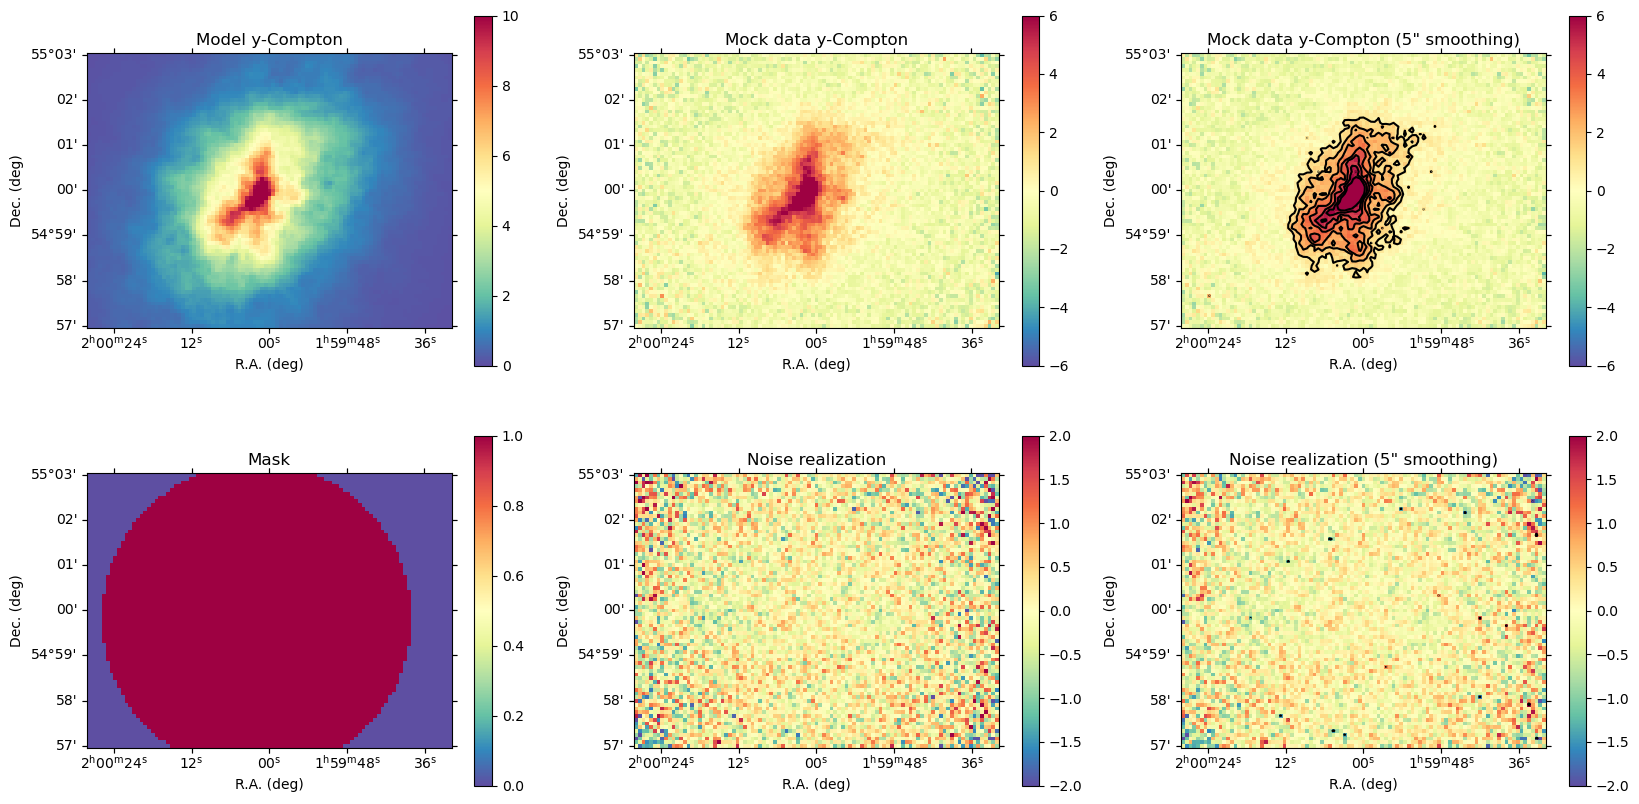

In [8]:
visu_smooth = 5

#===== Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(20, 10))

ax = plt.subplot(2, 3, 1, projection=WCS(data.header))
plt.imshow(mock.get_sz_map(no_fluctuations=False)*1e5, cmap='Spectral_r', vmin=0, vmax=10)
cb = plt.colorbar()
plt.title('Model y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 2, projection=WCS(data.header))
plt.imshow(data.image*1e5, cmap='Spectral_r',vmin=-6, vmax=6)
cb = plt.colorbar()
plt.title('Mock data y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 3, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-6, vmax=6)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[3,6,9,12,15,18,21], colors='k')
plt.title('Mock data y-Compton ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 4, projection=WCS(data.header))
plt.imshow(data.mask, cmap='Spectral_r', vmin=0, vmax=1)
cb = plt.colorbar()
plt.title('Mask')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 5, projection=WCS(data.header))
plt.imshow(data.noise_mc[0]*1e5, cmap='Spectral_r', vmin=-2, vmax=2)
cb = plt.colorbar()
plt.title('Noise realization')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 6, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-2, vmax=2)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[-3,3], colors='k')
plt.title('Noise realization ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

# Model fitting

(0.0005, 0.1)

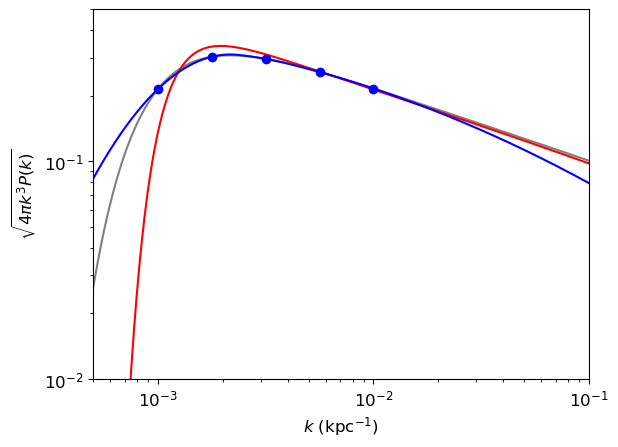

In [25]:
model1 = copy.deepcopy(mock) # Standard model using cutoff powerlaw
model2 = copy.deepcopy(mock) # Binned "user" model
model3 = copy.deepcopy(mock) # Binned "user" model

# Model 2 = Modified cutoff PL
model2.model_pressure_fluctuation = {'name': 'ModifiedCutoffPowerLaw',
                                     'statistics':fluct_statistics,
                                     'Norm': fluct_norm, 
                                     'slope': fluct_slope,
                                     'Linj': fluct_linj,
                                     'Ldis': 1*u.kpc,
                                     'Ninj':4, 
                                     'Ndis':3/2}

# Model 3 = Binned model
k3_in = np.logspace(np.log10(1), np.log10(10), 5)*u.Mpc**-1
_, pk3_in = model1.get_pressure_fluctuation_spectrum(k3_in)
model3.model_pressure_fluctuation = {'name': 'User',
                                     'statistics':fluct_statistics,
                                     'k': k3_in, 'pk':pk3_in}

# Show the models
k1, pk1 = model1.get_pressure_fluctuation_spectrum()
k2, pk2 = model2.get_pressure_fluctuation_spectrum()
k3, pk3 = model3.get_pressure_fluctuation_spectrum()
plt.loglog(k1.to_value('kpc-1'), (4*np.pi*k1**3*pk1).to_value('')**0.5, color='grey', label='Input: CutoffPowerLaw')
plt.loglog(k2.to_value('kpc-1'), (4*np.pi*k2**3*pk2).to_value('')**0.5, color='r', label='ModifiedCutoffPowerLaw')
plt.loglog(k3.to_value('kpc-1'), (4*np.pi*k3**3*pk3).to_value('')**0.5, color='b', label='User')
plt.loglog(k3_in.to_value('kpc-1'), (4*np.pi*k3_in**3*pk3_in).to_value('')**0.5, marker='o', ls='', color='b')
plt.xlabel(r'$k$ (kpc$^{-1}$)')
plt.ylabel(r'$\sqrt{4 \pi k^3 P(k)}$')
plt.ylim(1e-2,0.5)
plt.xlim(5e-4,1e-1)

### Standard functional form

In [10]:
inference1 = pitszi.InferenceFluctuation(data, model1, output_dir=output_dir+'/Inference1')

inference1.kbin_min   = kmin_pk
inference1.kbin_max   = kmax_pk
inference1.kbin_Nbin  = Nbins_pk
inference1.kbin_scale = scale_bins

inference1.mcmc_nwalkers = nwalkers
inference1.mcmc_nsteps   = nsteps
inference1.mcmc_burnin   = burnin
inference1.mcmc_reset    = mcmc_reset
inference1.mcmc_run      = mcmc_run
inference1.mcmc_Nresamp  = mcmc_Nresamp

inference1.method_use_covmat  = method_use_covmat
inference1.method_parallel    = method_parallel
inference1.method_data_deconv = method_data_deconv
inference1.set_method_w8(apply_radial_model=method_w8_radial, 
                        conv_radial_model_beam=method_w8_beam, conv_radial_model_TF=method_w8_TF, 
                        remove_GNFW_core=True, 
                        smooth_FWHM=method_w8_smooth)

if os.path.exists(inference1.output_dir+'/inference1_parameters.pkl') and method_setup_overwrite == False:
    inference1.load_inference(inference1.output_dir+'/inference1_parameters.pkl')
else:
    inference1.pk_setup()
    inference1.save_inference()
    os.rename(inference1.output_dir+'/inference_parameters.pkl', inference1.output_dir+'/inference1_parameters.pkl')

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                 Fluctuation Inference                      
------------------------------------------------------------
----- Checking the inputs -----
      - Data1, data2, and model projection OK.
----- Running the setup -----
The setup is necessary for inference on the power spectrum:
- Compute map resolution and k binning information         
- compute ymap residual to be used for Pk extraction       
- compute the smooth model                                 
- extract Pk data, reference model and noise properties    
- compute conversion from Pk 2d to Pk3d   

In [11]:
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.3],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    'Linj':{'guess':[800, 300],'unit': u.kpc,'limit':[100, 3000]}, #, 'prior':[800, 300],      
    'Anoise':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]},
              }

plist, popt, pcov = inference1.run_curvefit_fluctuation(fitpar_pk3d, include_model_error=True, 
                                                        show_fit_result=True, 
                                                        true_param=np.array([fluct_norm, fluct_slope, fluct_linj.value, 1]),                                                        
                                                        true_pk3d={'k':k1.to_value('kpc-1'), 'pk':pk1.to_value('kpc3')})

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
param 0 (Norm): 
   median   = 0.5657442242232955 -0.13844954413188898 +0.13613121179826415
   best-fit = 0.4617636431702355 -0.03446896307882896 +0.24011179285132417
   Norm = 0.5657442242232955_{-0.13844954413188898}^{0.13613121179826415}
param 1 (slope): 
   median   = -3.4232950330364567 -0.46819010921401505 +0.44706382233526565
   best-fit = -3.75562858136301 -0.13585656088746179 +0.7793973706618189
   slope = -3.4232950330364567_{-0.46819010921401505}^{0.44706382233526565}
param 2 (Linj): 
   median   = 755.361464819086 -191.51670205096252 +195.8836937261225
   best-fit = 757.8267687706385 -193.98200600251505 +193.41838977456996
   Linj = 755.361464819086_{-191.51670205096252}^{195.8836937261225}
param 3 (Anoise): 
   median   = 0.9872355036949646 -0.03177176852359587 +0.031655071054429995
   best-fit = 1.0060379529934003 -0.0505742

### Modified cutoff fit

In [12]:
inference2 = pitszi.InferenceFluctuation(data, model2, output_dir=output_dir+'/Inference2')

inference2.kbin_min   = kmin_pk
inference2.kbin_max   = kmax_pk
inference2.kbin_Nbin  = Nbins_pk
inference2.kbin_scale = scale_bins

inference2.mcmc_nwalkers = nwalkers
inference2.mcmc_nsteps   = nsteps
inference2.mcmc_burnin   = burnin
inference2.mcmc_reset    = mcmc_reset
inference2.mcmc_run      = mcmc_run
inference2.mcmc_Nresamp  = mcmc_Nresamp

inference2.method_use_covmat  = method_use_covmat
inference2.method_parallel    = method_parallel
inference2.method_data_deconv = method_data_deconv
inference2.set_method_w8(apply_radial_model=method_w8_radial, 
                        conv_radial_model_beam=method_w8_beam, conv_radial_model_TF=method_w8_TF, 
                        remove_GNFW_core=True, 
                        smooth_FWHM=method_w8_smooth)

if os.path.exists(inference2.output_dir+'/inference2_parameters.pkl') and method_setup_overwrite == False:
    inference2.load_inference(inference2.output_dir+'/inference2_parameters.pkl')
else:
    inference2.pk_setup()
    inference2.save_inference()
    os.rename(inference2.output_dir+'/inference_parameters.pkl', inference2.output_dir+'/inference2_parameters.pkl')

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                 Fluctuation Inference                      
------------------------------------------------------------
----- Checking the inputs -----
      - Data1, data2, and model projection OK.
----- Running the setup -----
The setup is necessary for inference on the power spectrum:
- Compute map resolution and k binning information         
- compute ymap residual to be used for Pk extraction       
- compute the smooth model                                 
- extract Pk data, reference model and noise properties    
- compute conversion from Pk 2d to Pk3d   

In [13]:
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.3],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    'Linj':{'guess':[800, 300],'unit': u.kpc,'limit':[100, 3000]}, #, 'prior':[800, 300],      
    'Ninj':{'guess':[2, 1],'unit': None,'limit':[0, 5]}, #, 'prior':[2, 1],      
    'Anoise':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]},
              }

plist, popt, pcov = inference2.run_curvefit_fluctuation(fitpar_pk3d, include_model_error=True, 
                                                        show_fit_result=True, 
                                                        true_param=np.array([fluct_norm, fluct_linj.value, 2, 1]),                                                        
                                                        true_pk3d={'k':k1.to_value('kpc-1'), 'pk':pk1.to_value('kpc3')})

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
param 0 (Norm): 
   median   = 0.5110493616553671 -0.03383064371608757 +0.033546327472884996
   best-fit = 0.49727147845409897 -0.020052760514819468 +0.0473242106741531
   Norm = 0.5110493616553671_{-0.03383064371608757}^{0.033546327472884996}
param 1 (Linj): 
   median   = 741.5891669854889 -147.3325837661913 +151.90266891360795
   best-fit = 740.9318832543921 -146.67530003509455 +152.5599526447047
   Linj = 741.5891669854889_{-147.3325837661913}^{151.90266891360795}
param 2 (Ninj): 
   median   = 2.155179368089164 -0.8021052342036863 +0.8327565814351994
   best-fit = 1.9677998574150035 -0.6147257235295258 +1.0201360921093598
   Ninj = 2.155179368089164_{-0.8021052342036863}^{0.8327565814351994}
param 3 (Anoise): 
   median   = 0.9977787085953292 -0.02764252098490949 +0.02657783488743448
   best-fit = 1.0014805439161218 -0.03134435630570

### Binned model fit

In [26]:
inference3 = pitszi.InferenceFluctuation(data, model3, output_dir=output_dir+'/Inference3')

inference3.kbin_min   = kmin_pk
inference3.kbin_max   = kmax_pk
inference3.kbin_Nbin  = Nbins_pk
inference3.kbin_scale = scale_bins

inference3.mcmc_nwalkers = nwalkers
inference3.mcmc_nsteps   = nsteps
inference3.mcmc_burnin   = burnin
inference3.mcmc_reset    = mcmc_reset
inference3.mcmc_run      = mcmc_run
inference3.mcmc_Nresamp  = mcmc_Nresamp

inference3.method_use_covmat  = method_use_covmat
inference3.method_parallel    = method_parallel
inference3.method_data_deconv = method_data_deconv
inference3.set_method_w8(apply_radial_model=method_w8_radial, 
                        conv_radial_model_beam=method_w8_beam, conv_radial_model_TF=method_w8_TF, 
                        remove_GNFW_core=True, 
                        smooth_FWHM=method_w8_smooth)

if os.path.exists(inference3.output_dir+'/inference3_parameters.pkl') and method_setup_overwrite == False:
    inference3.load_inference(inference3.output_dir+'/inference3_parameters.pkl')
else:
    inference3.pk_setup()
    inference3.save_inference()
    os.rename(inference3.output_dir+'/inference_parameters.pkl', inference3.output_dir+'/inference3_parameters.pkl')

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                 Fluctuation Inference                      
------------------------------------------------------------
----- Checking the inputs -----
      - Data1, data2, and model projection OK.
----- Running the setup -----
The setup is necessary for inference on the power spectrum:
- Compute map resolution and k binning information         
- compute ymap residual to be used for Pk extraction       
- compute the smooth model                                 
- extract Pk data, reference model and noise properties    
- compute conversion from Pk 2d to Pk3d   

In [41]:
#===== Curvefit with model error
fitpar_pk3d = {'User':{'guess':[pk3_in.value, pk3_in.value/5],
                       'prior':[pk3_in.value, pk3_in.value/10],
                       'unit': pk3_in.unit,
                       'limit':[0*pk3_in.value, np.inf*pk3_in.value]},
               'Anoise':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]},
              }

plist, popt, pcov = inference3.run_curvefit_fluctuation(fitpar_pk3d, include_model_error=True, 
                                                        show_fit_result=True, 
                                                        true_param=np.append(pk3_in.value, 1),
                                                        true_pk3d={'k':k1.to_value('kpc-1'), 'pk':pk1.to_value('kpc3')})

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
param 0 (Pk_bin_0): 
   median   = 2371736.1633901 -976594.995907798 +1005797.6039382662
   best-fit = 2256204.978420426 -861063.8109381241 +1121328.78890794
   Pk_bin_0 = 2371736.1633901_{-976594.995907798}^{1005797.6039382662}
param 1 (Pk_bin_1): 
   median   = 1186043.8994995328 -345696.98810668883 +344695.80504073785
   best-fit = 1111514.2994791956 -271167.3880863517 +419225.405061075
   Pk_bin_1 = 1186043.8994995328_{-345696.98810668883}^{344695.80504073785}
param 2 (Pk_bin_2): 
   median   = 285462.1413195669 -50942.947434394155 +50283.01686382748
   best-fit = 237984.1714844579 -3464.9775992851937 +97760.98669893644
   Pk_bin_2 = 285462.1413195669_{-50942.947434394155}^{50283.01686382748}
param 3 (Pk_bin_3): 
   median   = 75449.0643558027 -30931.465129500684 +31633.321516552067
   best-fit = 77007.4810215237 -32489.881795221685 +

(0.0005, 0.1)

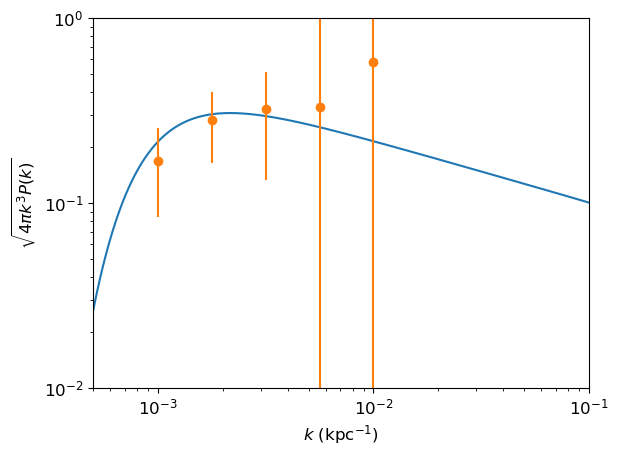

In [30]:
k, pk = mock.get_pressure_fluctuation_spectrum()
plt.loglog(k.to_value('kpc-1'), (4*np.pi*k**3*pk).to_value('')**0.5)

kmeas = inference3.model.model_pressure_fluctuation['k'].to_value('kpc-1')
pkmeas = popt[0:-1]
pkerr = (np.diag(pcov)[0:-1])**0.5
plt.errorbar(kmeas, (4*np.pi*kmeas**3*pkmeas)**0.5, (4*np.pi*kmeas**3*pkmeas)**(-0.5) * 4*np.pi*kmeas**3*pkerr, marker='o', ls='')
plt.xlabel(r'$k$ (kpc$^{-1}$)')
plt.ylabel(r'$\sqrt{4 \pi k^3 P(k)}$')
plt.ylim(1e-2, 1)
plt.xlim(5e-4,1e-1)

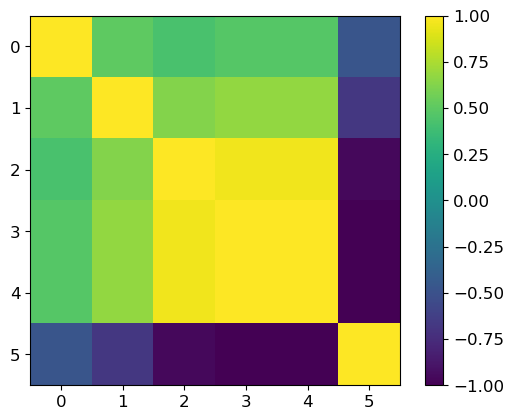

In [29]:
plt.imshow(pitszi.utils.correlation_from_covariance(pcov), vmin=-1, vmax=1)
plt.colorbar()

In [45]:
#===== MCMC with model error
fitpar_pk3d = {'User':{'guess':[pk3_in.value, pk3_in.value/5],
                       #'prior':[pk3_in.value, pk3_in.value/10],
                       'unit': pk3_in.unit,
                       'limit':[0*pk3_in.value, np.inf*pk3_in.value]},
               'Anoise':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]},
              }

plist, sampler = inference3.run_mcmc_fluctuation(fitpar_pk3d, kind='projection',
                                                 include_model_error=True,
                                                 filename_sampler=None,
                                                 show_fit_result=True, 
                                                 true_param=np.append(pk3_in.value, 1),
                                                 true_pk3d={'k':k1.to_value('kpc-1'), 'pk':pk1.to_value('kpc3')})

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/adam/Desktop/pitszi//Inference3/pitszi_MCMC_Fluctuation_projection_sampler.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Pk_bin_0' 'Pk_bin_1' 'Pk_bin_2' 'Pk_bin_3' 'Pk_bin_4' 'Anoise']
      - Starting point mean:          
[3.67728712e+06 1.29675402e+06 2.20250505e+05 2.96920801e+04
 3.72063576e+03 1.00000000e+00]
      - Starting point dispersion :   
[7.35457424e+05 2.59350804e+05 4.40501011e+04 5.93841602e+03
 7.44127151e+02 2.00000000e-01]
      - Minimal starting point:       
[0. 0. 0. 0. 0. 0.]
      - Maximal starting point:       
[inf inf inf inf inf  2.]
      - Number of dimensions:         
6
      - Parallel mode:                
False
      - Use covariance matrix?        
False
-----
----- Does the sampler already exist? -----
      - Yes, but reset

100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [1:05:39<00:00,  7.88s/it]


param 0 (Pk_bin_0): 
   median   = 1955636.0748762048 -1067122.9476312504 +1030454.7306867905
   best-fit = 2220769.440069417 -1332256.3128244625 +765321.3654935784
   Pk_bin_0 = 1955636.0748762048_{-1067122.9476312504}^{1030454.7306867905}
param 1 (Pk_bin_1): 
   median   = 1268540.4437738727 -293191.909067712 +372729.892941169
   best-fit = 1122035.3396502996 -146686.80494413897 +519234.997064742
   Pk_bin_1 = 1268540.4437738727_{-293191.909067712}^{372729.892941169}
param 2 (Pk_bin_2): 
   median   = 264858.17996569653 -52680.28314327804 +56458.338922076684
   best-fit = 261702.4419227619 -49524.545100343414 +59614.07696501131
   Pk_bin_2 = 264858.17996569653_{-52680.28314327804}^{56458.338922076684}
param 3 (Pk_bin_3): 
   median   = 50869.763122030156 -15117.955374454017 +38946.686230176376
   best-fit = 58031.685321033816 -22279.877573457677 +31784.764031172715
   Pk_bin_3 = 50869.763122030156_{-15117.955374454017}^{38946.686230176376}
param 4 (Pk_bin_4): 
   median   = 24492.591

(0.0005, 0.1)

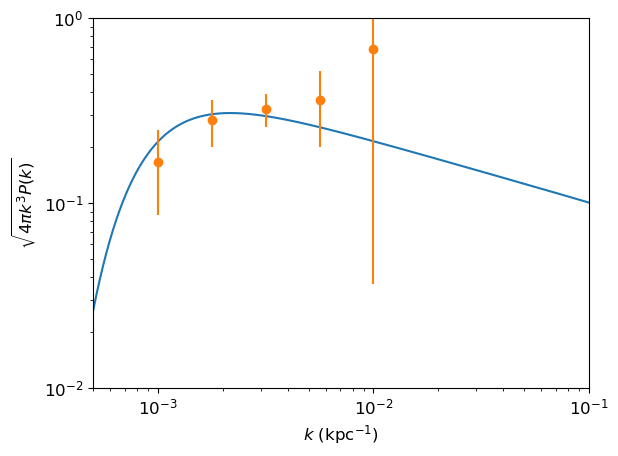

In [62]:
w = sampler.flatlnprobability == np.amax(sampler.flatlnprobability)
popt = sampler.flatchain[w][0]
pstd = np.std(sampler.flatchain, axis=0)

k, pk = mock.get_pressure_fluctuation_spectrum()
plt.loglog(k.to_value('kpc-1'), (4*np.pi*k**3*pk).to_value('')**0.5)

kmeas = inference3.model.model_pressure_fluctuation['k'].to_value('kpc-1')
pkmeas = popt[0:-1]
pkerr = pstd[0:-1]
plt.errorbar(kmeas, (4*np.pi*kmeas**3*pkmeas)**0.5, (4*np.pi*kmeas**3*pkmeas)**(-0.5) * 4*np.pi*kmeas**3*pkerr, marker='o', ls='')
plt.xlabel(r'$k$ (kpc$^{-1}$)')
plt.ylabel(r'$\sqrt{4 \pi k^3 P(k)}$')
plt.ylim(1e-2, 1)
plt.xlim(5e-4,1e-1)

In [75]:
#===== Curvefit without model error and same bins as pk2d
k3_in = inference3._kctr_kpc[0:-4]*u.kpc**-1
_, pk3_in = model1.get_pressure_fluctuation_spectrum(k3_in)
inference3.model.model_pressure_fluctuation = {'name': 'User','statistics':fluct_statistics,'k': k3_in, 'pk':pk3_in}

fitpar_pk3d = {'User':{'guess':[pk3_in.value, pk3_in.value/5],
                       'unit': pk3_in.unit,
                       'limit':[0*pk3_in.value, np.inf*pk3_in.value]},
               'Anoise':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]},
              }

plist, popt, pcov = inference3.run_curvefit_fluctuation(fitpar_pk3d, include_model_error=False, 
                                                        show_fit_result=True, 
                                                        true_param=np.append(pk3_in.value, 1),
                                                        true_pk3d={'k':k1.to_value('kpc-1'), 'pk':pk1.to_value('kpc3')})

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
param 0 (Pk_bin_0): 
   median   = 4.038365202465923e-08 -2.7797375074402303e-08 +4.364435221143995e-08
   best-fit = 1.5304660129254383e-08 -2.7183831789974587e-09 +6.872334410684479e-08
   Pk_bin_0 = 4.038365202465923e-08_{-2.7797375074402303e-08}^{4.364435221143995e-08}
param 1 (Pk_bin_1): 
   median   = 376348.91478629096 -76822.6043312021 +95887.74171728181
   best-fit = 316344.66393824655 -16818.353483157698 +155891.99256532622
   Pk_bin_1 = 376348.91478629096_{-76822.6043312021}^{95887.74171728181}
param 2 (Pk_bin_2): 
   median   = 4854493.427945998 -94548.32560417335 +87949.85346384998
   best-fit = 4897564.178474527 -137619.07613270264 +44879.1029353207
   Pk_bin_2 = 4854493.427945998_{-94548.32560417335}^{87949.85346384998}
param 3 (Pk_bin_3): 
   median   = 1012260.4018922254 -188597.74450883002 +186643.6922592112
   best-fit 

(0.0005, 0.1)

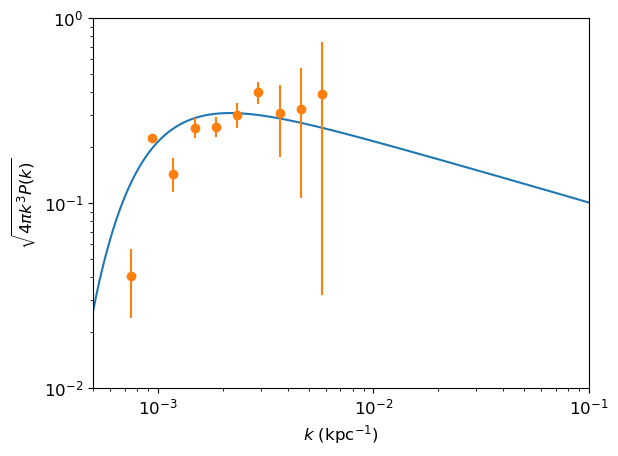

In [76]:
k, pk = mock.get_pressure_fluctuation_spectrum()
plt.loglog(k.to_value('kpc-1'), (4*np.pi*k**3*pk).to_value('')**0.5)

kmeas = inference3.model.model_pressure_fluctuation['k'].to_value('kpc-1')
pkmeas = popt[0:-1]
pkerr = (np.diag(pcov)[0:-1])**0.5
plt.errorbar(kmeas, (4*np.pi*kmeas**3*pkmeas)**0.5, (4*np.pi*kmeas**3*pkmeas)**(-0.5) * 4*np.pi*kmeas**3*pkerr, marker='o', ls='')
plt.xlabel(r'$k$ (kpc$^{-1}$)')
plt.ylabel(r'$\sqrt{4 \pi k^3 P(k)}$')
plt.ylim(1e-2, 1)
plt.xlim(5e-4,1e-1)

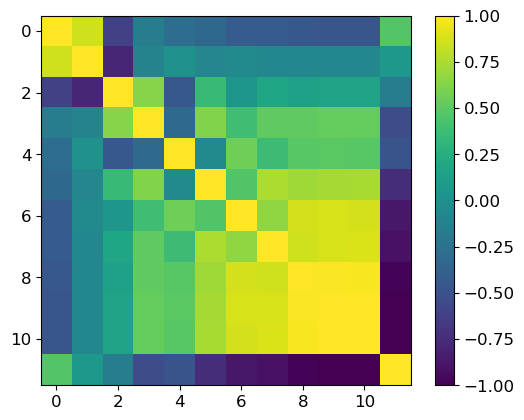

In [77]:
plt.imshow(pitszi.utils.correlation_from_covariance(pcov), vmin=-1, vmax=1)
plt.colorbar()